In [66]:
%autoreload 2

UsageError: Line magic function `%autoreload` not found.


In [67]:
import torch

In [68]:
from collections import defaultdict, Counter
from itertools import combinations, chain
import json
from types import SimpleNamespace
import typing


import colorcet as cc
import krippendorff
from IPython.display import display, HTML, Markdown
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import sklearn.feature_extraction.text as sk_text
from sklearn.manifold import TSNE
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tabulate import tabulate
from textblob import TextBlob
import torch
from transformers import pipeline


In [69]:
class ExtendedSimpleNamespace(SimpleNamespace):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __contains__(self, key):
        return hasattr(self, key)

    def __getitem__(self, key):
        return getattr(self, key)

    def get(self, key, default=None):
        return getattr(self, key, default)

    def keys(self):
        return [k for k in vars(self).keys() if not k.startswith("_")]
        

In [70]:
TOP_30_UNMATCHED_FULL_GAME_IDS = [
    '(1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1)-unmatched',
    '(1, 1, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0)-unmatched',
    '(1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0)-unmatched',
    '(1, 1, 4, 0, 0, 1, 1, 1, 0, 1, 0, 0)-unmatched',
    '(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)-unmatched',
    '(1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1)-unmatched',
    '(1, 0, 4, 0, 0, 0, 0, 0, 3, 0, 0, 0)-unmatched',
    '(1, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 1)-unmatched',
    '(1, 1, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0)-unmatched',
    '(1, 0, 4, 0, 1, 1, 0, 1, 0, 1, 0, 0)-unmatched',
    '(1, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0)-unmatched',
    '(1, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0)-unmatched',
    '(1, 1, 3, 0, 0, 1, 0, 0, 1, 0, 0, 0)-unmatched',
    '(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)-unmatched',
    '(1, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0)-unmatched',
    '(1, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0)-unmatched',
    '(1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 1, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 1, 3, 1, 0, 0, 1, 0, 0, 0, 1, 0)-unmatched',
    '(1, 1, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0)-unmatched',
    '(1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0)-unmatched',
    '(1, 1, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 1, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0)-unmatched',
    '(1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0)-unmatched',
    '(1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0)-unmatched',
 ]

In [124]:
PREVIOUS_DATA_PATH = './human_evals_data/real-complete_only-main-pilot_02-01_data.json'
CURRENT_DATA_PATH = './human_evals_data/real-complete_only-main-pilot_02-02_data.json'

GAME_KEYS = [
    'id', 'real', 'matched', 
    'confident', 'fun_play', 'fun_watch', 
    'capability', 'goldilocks', 'creativity',
    'human-likeness', 'explain', 'overall'
]

RENAMED_GAME_KEYS = {
    'id': 'game_id',
    'human-likeness': 'human_likeness'
}

NUMBER_SCORE_ATTRIBUTES = [
    'confident', 'fun_play', 
    'fun_watch',  'capability', 
    'goldilocks', 'creativity',
    'human_likeness',
]

NUMBER_SCORE_AXIS_NAMES = {
    'confident': 'How confident are you that you understand the game?',
    'fun_play': 'How fun would it be to play the game yourself?',
    'fun_watch': 'How fun would it be to watch someone else play the game?',
    'capability': 'How helpful would it be for learning to interact',
    'goldilocks': 'Too easy, appropriately difficult, or too hard for you?',
    'creativity': 'How creatively designed is the game?',
    'human_likeness': 'How human-like do you think this game is?',
}


def load_data(data_path: str) -> typing.Tuple[typing.List[ExtendedSimpleNamespace], typing.List[ExtendedSimpleNamespace]]:
    with open(data_path, 'r') as f:
        raw_data = json.load(f, object_hook=lambda d: ExtendedSimpleNamespace(**d))

    prolific_participants_data = []
    non_prolific_participants_data = []

    for participant_data in raw_data:
        if participant_data.data.recruitment_service == 'prolific':
            prolific_participants_data.append(participant_data)
        else:
            non_prolific_participants_data.append(participant_data)

    return prolific_participants_data, non_prolific_participants_data


def real_matched_to_str(series: pd.Series) -> str:
    if series.real:
        return 'real'

    if series.matched:
        return 'matched'

    return 'unmatched'


def full_game_id_to_str(series: pd.Series) -> str:
    return f"{series.game_id}-{series.game_type}"


def loaded_data_to_df(loaded_data: typing.List[ExtendedSimpleNamespace]):
    rows = []

    for participant in loaded_data:
        participant_id = participant.id

        for game_result in participant.data.single_game_results:
            rows.append({
                'participant_id': participant_id,
                **{RENAMED_GAME_KEYS.get(key, key): game_result[key] for key in GAME_KEYS}
            })
    
    df = pd.DataFrame(rows)
    df = df.assign(game_type=df.apply(real_matched_to_str, axis=1))
    df = df.assign(full_game_id=df.apply(full_game_id_to_str, axis=1))

    top_30_df = df[df.full_game_id.isin(TOP_30_UNMATCHED_FULL_GAME_IDS)].copy()
    top_30_df.game_type = 'unmatched_top_30'
    top_30_df = top_30_df.assign(full_game_id=top_30_df.apply(full_game_id_to_str, axis=1))

    df = pd.concat([df, top_30_df])
    df = df.assign(game_type=pd.Categorical(df.game_type, categories=['real', 'matched', 'unmatched', 'unmatched_top_30'], ordered=True))
    
    return df


def load_data_to_df(data_path: str, prolific_only: bool = True):
    prolific_participants_data, non_prolific_participants_data = load_data(data_path)
    if not prolific_only:
        prolific_participants_data.extend(non_prolific_participants_data)

    prolific_participants_data = list(filter(lambda p: p.data.get('quiz_passed', True), prolific_participants_data))

    return prolific_participants_data, loaded_data_to_df(prolific_participants_data)


current_participants_raw_data, current_participants_df = load_data_to_df(CURRENT_DATA_PATH)
previous_participants_raw_data, previous_participants_df = load_data_to_df(PREVIOUS_DATA_PATH)
print(f'Loaded current participant data with shape {current_participants_df.shape} from {CURRENT_DATA_PATH}')
print(f'Loaded previous participant data with shape {previous_participants_df.shape} from {PREVIOUS_DATA_PATH}')

current_participant_ids = set(current_participants_df.participant_id)
previous_participant_ids = set(previous_participants_df.participant_id)
new_participant_ids = current_participant_ids - previous_participant_ids
print(f"{len(current_participant_ids)} total participants | {len(new_participant_ids)} new participants:")
for participant_id in sorted(new_participant_ids):
    print(f"\t{participant_id}")

print(f'Dataframe shape: {current_participants_df.shape}')
current_participants_df.head()


Loaded current participant data with shape (1292, 15) from ./human_evals_data/real-complete_only-main-pilot_02-02_data.json
Loaded previous participant data with shape (1279, 15) from ./human_evals_data/real-complete_only-main-pilot_02-01_data.json
100 total participants | 1 new participants:
	37db5bea-1840-49a8-96af-840f5322fd21-p207
Dataframe shape: (1292, 15)


,participant_id,game_id,real,matched,confident,fun_play,fun_watch,capability,goldilocks,creativity,human_likeness,explain,overall,game_type,full_game_id
0,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)",False,False,4,3,3,5,3,2,2,"The game is composed of two components. First,...",The instructions seem to be pretty straightfor...,unmatched,"(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)-unmatched"
1,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)",False,False,4,3,3,4,3,3,2,"First, you need to place the hexagon bin near ...",This games seems slightly more difficult that ...,unmatched,"(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)-unmatched"
2,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",True,True,4,2,2,5,4,3,2,"First, you need to put the bin next to the bed...",This game is more challenging than the prior t...,real,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)-real"
3,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",False,True,5,4,4,3,2,2,2,Place the bin next to the wall. Throw balls t...,This game has the simplest instructions. One c...,matched,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)-matched"
4,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 1, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0)",False,False,1,1,1,1,5,1,3,Move chairs and then let them go so they end u...,I don't like this game. I don't really unders...,unmatched,"(1, 1, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0)-unmatched"


## Filter Responses

In [153]:
def word_count(str):
    return len(str.split(" "))

QUANTILE = 0.

min_response_length = current_participants_df["overall"].apply(word_count).quantile(QUANTILE)
filtered_participants_df = current_participants_df[current_participants_df["overall"].apply(word_count) >= min_response_length]


print(f"There are {len(filtered_participants_df)} responses with at least {min_response_length} words ({100*QUANTILE}th percentile)")

There are 1292 responses with at least 1.0 words (0.0th percentile)


In [154]:
real_games_df = filtered_participants_df[(filtered_participants_df["real"] == True) & (filtered_participants_df["matched"] == True)]
matched_games_df = filtered_participants_df[(filtered_participants_df["real"] == False) & (filtered_participants_df["matched"] == True)]
unmatched_games_df = filtered_participants_df[(filtered_participants_df["real"] == False) & (filtered_participants_df["matched"] == False)]

## Sentiment Analysis

In [155]:
def get_sentiment(text: str) -> float:
    return TextBlob(text).sentiment.polarity

# Add sentiment analysis to the dataframes
real_games_df = real_games_df.assign(explain_sentiment=real_games_df.explain.apply(get_sentiment))
matched_games_df = matched_games_df.assign(explain_sentiment=matched_games_df.explain.apply(get_sentiment))
unmatched_games_df = unmatched_games_df.assign(explain_sentiment=unmatched_games_df.explain.apply(get_sentiment))

real_games_df = real_games_df.assign(overall_sentiment=real_games_df.overall.apply(get_sentiment))
matched_games_df = matched_games_df.assign(overall_sentiment=matched_games_df.overall.apply(get_sentiment))
unmatched_games_df = unmatched_games_df.assign(overall_sentiment=unmatched_games_df.overall.apply(get_sentiment))

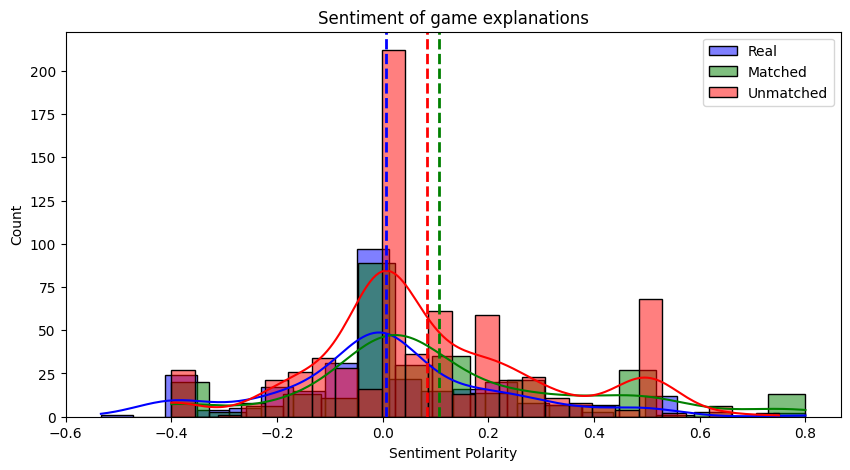

In [156]:
# Overlapping histograms of sentiment
plt.figure(figsize=(10, 5))
sns.histplot(real_games_df.explain_sentiment, kde=True, color='blue', label='Real')
sns.histplot(matched_games_df.explain_sentiment, kde=True, color='green', label='Matched')
sns.histplot(unmatched_games_df.explain_sentiment, kde=True, color='red', label='Unmatched')

# Vertical lines at the mean sentiment for each game type
plt.axvline(real_games_df.explain_sentiment.mean(), color='blue', linestyle='dashed', linewidth=2)
plt.axvline(matched_games_df.explain_sentiment.mean(), color='green', linestyle='dashed', linewidth=2)
plt.axvline(unmatched_games_df.explain_sentiment.mean(), color='red', linestyle='dashed', linewidth=2)

plt.title('Sentiment of game explanations')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Count')
plt.legend()

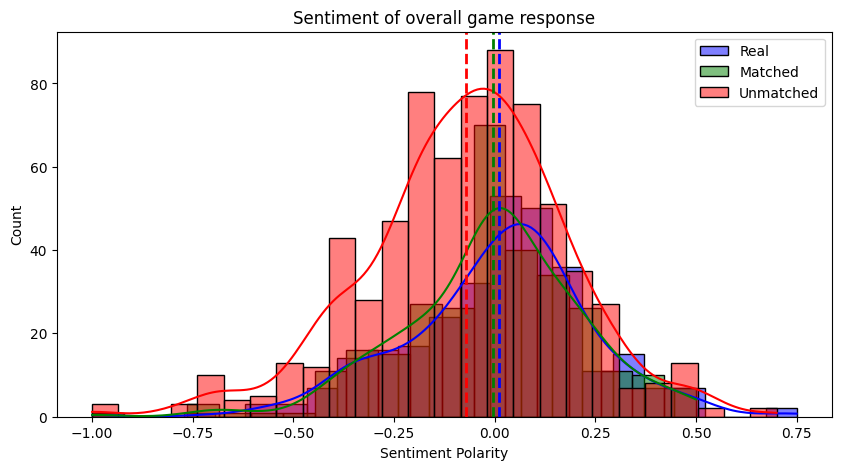

In [157]:
# Overlapping histograms of sentiment
plt.figure(figsize=(10, 5))
sns.histplot(real_games_df.overall_sentiment, kde=True, color='blue', label='Real')
sns.histplot(matched_games_df.overall_sentiment, kde=True, color='green', label='Matched')
sns.histplot(unmatched_games_df.overall_sentiment, kde=True, color='red', label='Unmatched')

# Vertical lines at the mean sentiment for each game type
plt.axvline(real_games_df.overall_sentiment.mean(), color='blue', linestyle='dashed', linewidth=2)
plt.axvline(matched_games_df.overall_sentiment.mean(), color='green', linestyle='dashed', linewidth=2)
plt.axvline(unmatched_games_df.overall_sentiment.mean(), color='red', linestyle='dashed', linewidth=2)

plt.title('Sentiment of overall game response')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Count')
plt.legend()

In [158]:
# Fightin' Words implementation from Kenneth Lim (https://github.com/kenlimmj/fightin-words/blob/master/fightin-words/fightin-words.py)
import numpy as np
import sklearn.base as sk_base
import sklearn.feature_extraction.text as sk_text


class FWExtractor(sk_base.BaseEstimator, sk_base.TransformerMixin):
    """Compute Monroe et. al's [Monroe2008] fightin' words result.

    Largely derived from Jack Hessel's original implementation [Hessel2015]
    but modified to be compliant with scikit-learn conventions (for use in
    pipelines, etc.). Also some small technical improvements.

    Parameters
    ----------
    prior: float or list, default=0.01

        Starting Dirichlet prior that is smoothed over the input. If a float is
        provided, a uniform distribution is created over the vocabulary
        extracted from the corpora. If a list is provided, it is assumed that
        the user will _also_ be passing in their own count vectorizer, and that
        the dimensionality of both items match each other.

    cv: sklearn.feature_extraction.text.CountVectorizer or
        sklearn.feature_extraction.text.TfidfVectorizer or None, optional

        The vectorizer used to construct the word-occurrence frequency
        dictionary. If not specified, uses the default parameters for a naive
        implementation of scikit-learn's `CountVectorizer`.

    References
    ----------
    .. [Monroe2008] `Monroe, B. L., Colaresi, M. P., & Quinn, K. M. (2008).
                     Fightin'words: Lexical feature selection and evaluation
                     for identifying the content of political conflict.
                     Political Analysis, 16(4), 372-403.`
    .. [Hessel2015] `https://github.com/jmhessel/FightingWords`
    """

    def __init__(self, prior=0.01, cv=None):
        # type: (Union[float, List[float]], Optional[sk_text.CountVectorizer, sk_text.TfidfVectorizer]) -> None

        if cv is None:
            # Use the default scikit-learn vectorizer with sane defaults
            self.cv = sk_text.CountVectorizer(decode_error='ignore', max_features=15000)
        elif not (isinstance(cv, sk_text.CountVectorizer) or isinstance(cv, sk_text.TfidfVectorizer)):
            raise TypeError(cv, 'Expected a scikit-learn CountVectorizer or TfidfVectorizer')
        else:
            self.cv = cv

        if not (isinstance(prior, list) or isinstance(prior, float)):
            raise TypeError(prior, 'Expected either a list or a float')
        else:
            self.prior = prior

    def fit(self, X, y=None, **params):
        """Unused"""
        return self

    def transform(self, X, **params):
        """Perform a comparison between two corpora, and compute/rank the z-scores for word tokens

        Parameters
        ----------
        X: list, [str, str]

            Pair of text corpora to be compared.
        """
        # type Sequence[str, str] -> List[Sequence[str, float]]

        # Compute Bag-of-words Model.
        counts = self.cv.fit_transform([' '.join(X)]).toarray()
        vocab_size = len(self.cv.vocabulary_)

        # Create a reverse-LUT to remap the vocabulary to human-readable words.
        index_to_term = {v: k for k, v in self.cv.vocabulary_.items()}

        if isinstance(self.prior, float):
            # Generate uniform prior distribution
            self.priors = [self.prior for i in range(vocab_size)]
        else:
            # Guaranteed to be dealing with a list in this block because the
            # class constructor would have caught bad types at initialization.
            if (len(self.prior) == vocab_size):
                self.priors = self.prior
            else:
                raise AssertionError(self.prior, 'Number of priors must match vocabulary size')

        z_scores = np.empty(np.array(self.priors).shape[0])
        count_matrix = np.empty([2, vocab_size], dtype=np.float32)

        count_matrix[0, :] = np.sum(counts[:len(X[0]), :], axis=0)
        count_matrix[1, :] = np.sum(counts[len(X[0]):, :], axis=0)

        a0 = np.sum(self.priors)

        n1 = np.sum(count_matrix[0, :], dtype=np.float32)
        n2 = np.sum(count_matrix[1, :], dtype=np.float32)

        for i in range(vocab_size):
            # Compute delta.
            term1 = np.log((count_matrix[0, i] + self.priors[i]) / (n1 + a0 - count_matrix[0, i] - self.priors[i]))
            term2 = np.log((count_matrix[1, i] + self.priors[i]) / (n2 + a0 - count_matrix[1, i] - self.priors[i]))
            delta = term1 - term2

            # Compute variance and standardize the z-score.
            var = 1 / (count_matrix[0, i] + self.priors[i]) + 1 / (count_matrix[1, i] + self.priors[i])
            z_scores[i] = delta / np.sqrt(var)

        # Return the results in descending order.
        return [(index_to_term[i], z_scores[i]) for i in np.argsort(z_scores)]

## Fightin' Words

In [159]:
real_explanation_text = " ".join(real_games_df.explain.tolist())
real_overall_text = " ".join(real_games_df.overall.tolist())

matched_explanation_text = " ".join(matched_games_df.explain.tolist())
matched_overall_text = " ".join(matched_games_df.overall.tolist())

unmatched_explanation_text = " ".join(unmatched_games_df.explain.tolist())
unmatched_overall_text = " ".join(unmatched_games_df.overall.tolist())

In [160]:
prior = 0.05
cv = sk_text.CountVectorizer(max_features=15000)

real_vs_matched_explanations = FWExtractor(prior, cv).fit_transform([real_explanation_text, matched_explanation_text])
real_vs_unmatched_explanations = FWExtractor(prior, cv).fit_transform([real_explanation_text, unmatched_explanation_text])
matched_vs_unmatched_explanations = FWExtractor(prior, cv).fit_transform([matched_explanation_text, unmatched_explanation_text])

real_vs_matched_overall = FWExtractor(prior, cv).fit_transform([real_overall_text, matched_overall_text])
real_vs_unmatched_overall = FWExtractor(prior, cv).fit_transform([real_overall_text, unmatched_overall_text])
matched_vs_unmatched_overall = FWExtractor(prior, cv).fit_transform([matched_overall_text, unmatched_overall_text])

In [161]:
def plot_fightin_words(fw_results, title, k=10):
    fw_results = fw_results[:k] + fw_results[-k:]
    words = [x[0] for x in fw_results]
    scores = [x[1] for x in fw_results]

    plt.figure(figsize=(10, 5))
    plt.barh(words, scores, color='blue')
    plt.title(title)
    plt.xlabel('Z-score')
    plt.ylabel('Word')
    plt.show()

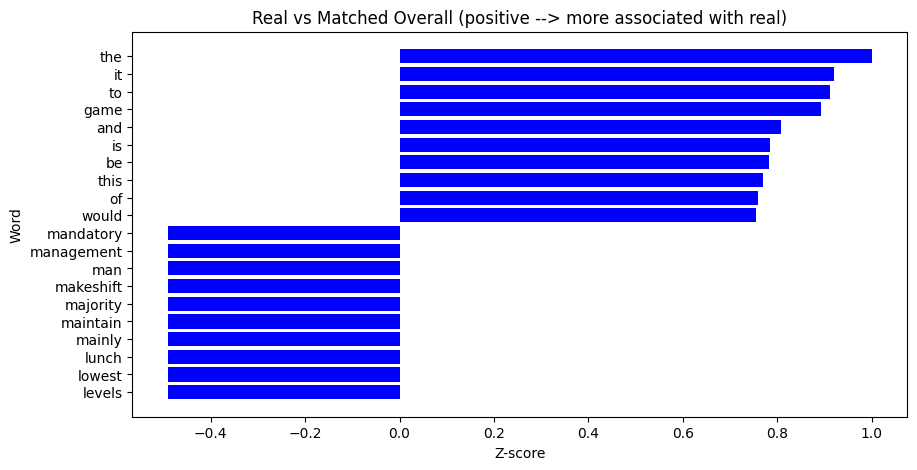

In [162]:
plot_fightin_words(real_vs_matched_overall, 'Real vs Matched Overall (positive --> more associated with real)')

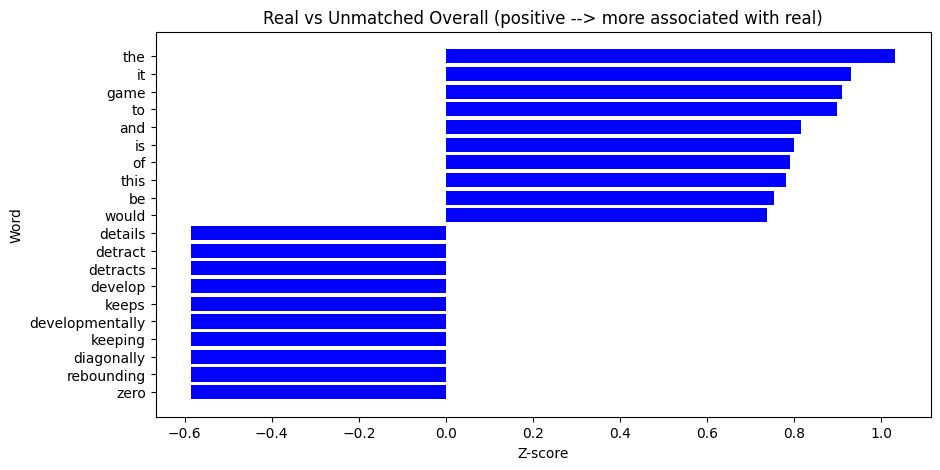

In [163]:
plot_fightin_words(real_vs_unmatched_overall, 'Real vs Unmatched Overall (positive --> more associated with real)')

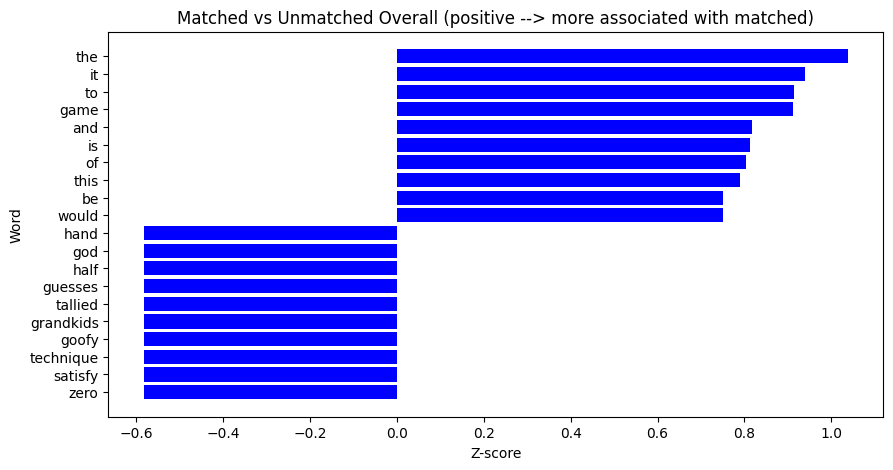

In [164]:
plot_fightin_words(matched_vs_unmatched_overall, 'Matched vs Unmatched Overall (positive --> more associated with matched)')

## Embeddings

In [165]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

In [176]:
real_overall_embeddings = embedding_model.encode(real_games_df.overall.tolist())
real_explanation_embeddings = embedding_model.encode(real_games_df.explain.tolist())

matched_overall_embeddings = embedding_model.encode(matched_games_df.overall.tolist())
matched_explanation_embeddings = embedding_model.encode(matched_games_df.explain.tolist())

unmatched_overall_embeddings = embedding_model.encode(unmatched_games_df.overall.tolist())
unmatched_explanation_embeddings = embedding_model.encode(unmatched_games_df.explain.tolist())

In [177]:
# According to FAQ, using PCA to reduce the dimensionality to ~50 is good to do before t-SNE
pca = PCA(n_components=50)
real_overall_embeddings_pca = pca.fit_transform(real_overall_embeddings)
real_explanation_embeddings_pca = pca.fit_transform(real_explanation_embeddings)

matched_overall_embeddings_pca = pca.fit_transform(matched_overall_embeddings)
matched_explanation_embeddings_pca = pca.fit_transform(matched_explanation_embeddings)

unmatched_overall_embeddings_pca = pca.fit_transform(unmatched_overall_embeddings)
unmatched_explanation_embeddings_pca = pca.fit_transform(unmatched_explanation_embeddings)

In [186]:
# Assign the PCA-reduced embeddings back to the dataframes
real_games_df = real_games_df.assign(overall_embedding=real_overall_embeddings_pca.tolist())
real_games_df = real_games_df.assign(explain_embedding=real_explanation_embeddings_pca.tolist())

matched_games_df = matched_games_df.assign(overall_embedding=matched_overall_embeddings_pca.tolist())
matched_games_df = matched_games_df.assign(explain_embedding=matched_explanation_embeddings_pca.tolist())

unmatched_games_df = unmatched_games_df.assign(overall_embedding=unmatched_overall_embeddings_pca.tolist())
unmatched_games_df = unmatched_games_df.assign(explain_embedding=unmatched_explanation_embeddings_pca.tolist())

In [178]:
tsne = TSNE(n_components=2, random_state=0)
real_overall_embeddings_tsne = tsne.fit_transform(real_overall_embeddings_pca)
real_explanation_embeddings_tsne = tsne.fit_transform(real_explanation_embeddings_pca)

matched_overall_embeddings_tsne = tsne.fit_transform(matched_overall_embeddings_pca)
matched_explanation_embeddings_tsne = tsne.fit_transform(matched_explanation_embeddings_pca)

unmatched_overall_embeddings_tsne = tsne.fit_transform(unmatched_overall_embeddings_pca)
unmatched_explanation_embeddings_tsne = tsne.fit_transform(unmatched_explanation_embeddings_pca)

In [179]:
# Assign the t-SNE embeddings back to the dataframe
real_games_df = real_games_df.assign(overall_tsne1=real_overall_embeddings_tsne[:, 0])
real_games_df = real_games_df.assign(overall_tsne2=real_overall_embeddings_tsne[:, 1])

real_games_df = real_games_df.assign(explain_tsne1=real_explanation_embeddings_tsne[:, 0])
real_games_df = real_games_df.assign(explain_tsne2=real_explanation_embeddings_tsne[:, 1])

matched_games_df = matched_games_df.assign(overall_tsne1=matched_overall_embeddings_tsne[:, 0])
matched_games_df = matched_games_df.assign(overall_tsne2=matched_overall_embeddings_tsne[:, 1])

matched_games_df = matched_games_df.assign(explain_tsne1=matched_explanation_embeddings_tsne[:, 0])
matched_games_df = matched_games_df.assign(explain_tsne2=matched_explanation_embeddings_tsne[:, 1])

unmatched_games_df = unmatched_games_df.assign(overall_tsne1=unmatched_overall_embeddings_tsne[:, 0])
unmatched_games_df = unmatched_games_df.assign(overall_tsne2=unmatched_overall_embeddings_tsne[:, 1])

unmatched_games_df = unmatched_games_df.assign(explain_tsne1=unmatched_explanation_embeddings_tsne[:, 0])
unmatched_games_df = unmatched_games_df.assign(explain_tsne2=unmatched_explanation_embeddings_tsne[:, 1])

In [187]:
# Also, assign the sum of all numerical ratings to the dataframe
real_games_df = real_games_df.assign(sum_ratings=real_games_df[NUMBER_SCORE_ATTRIBUTES].sum(axis=1))
matched_games_df = matched_games_df.assign(sum_ratings=matched_games_df[NUMBER_SCORE_ATTRIBUTES].sum(axis=1))
unmatched_games_df = unmatched_games_df.assign(sum_ratings=unmatched_games_df[NUMBER_SCORE_ATTRIBUTES].sum(axis=1))

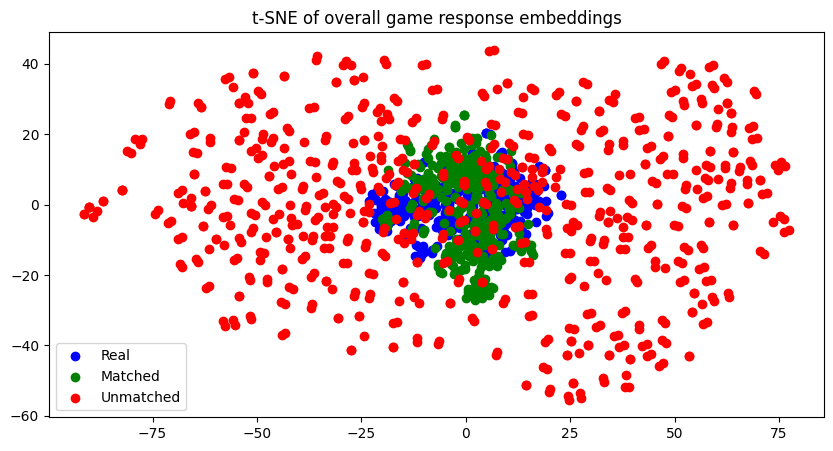

In [181]:
# First up, scatter plot the embeddings
plt.figure(figsize=(10, 5))
plt.scatter(real_games_df["overall_tsne1"], real_games_df["overall_tsne2"], color='blue', label='Real')
plt.scatter(matched_games_df["overall_tsne1"], matched_games_df["overall_tsne2"], color='green', label='Matched')
plt.scatter(unmatched_games_df["overall_tsne1"], unmatched_games_df["overall_tsne2"], color='red', label='Unmatched')
plt.title('t-SNE of overall game response embeddings')
plt.legend()

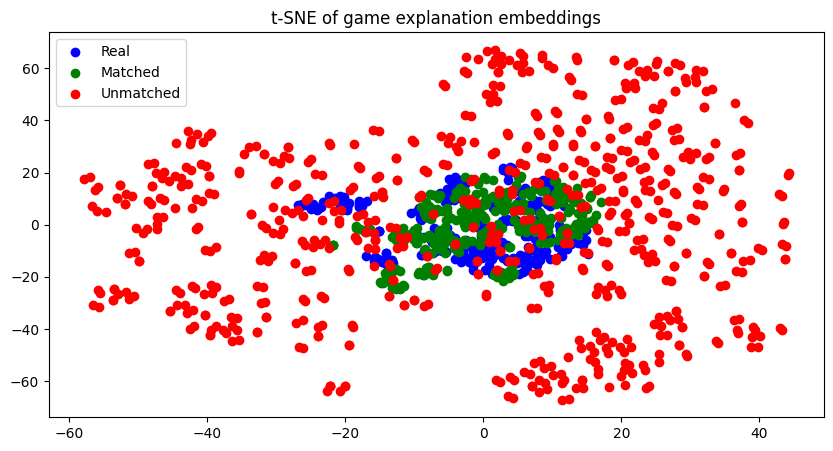

In [183]:
plt.figure(figsize=(10, 5))
plt.scatter(real_games_df["explain_tsne1"], real_games_df["explain_tsne2"], color='blue', label='Real')
plt.scatter(matched_games_df["explain_tsne1"], matched_games_df["explain_tsne2"], color='green', label='Matched')
plt.scatter(unmatched_games_df["explain_tsne1"], unmatched_games_df["explain_tsne2"], color='red', label='Unmatched')
plt.title('t-SNE of game explanation embeddings')
plt.legend()

In [188]:
joined_df = pd.concat([real_games_df, matched_games_df, unmatched_games_df])

/var/folders/rd/wt3q313n7j9002x_474dmbz00000gn/T/ipykernel_37366/4121808044.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('RdYlBu')


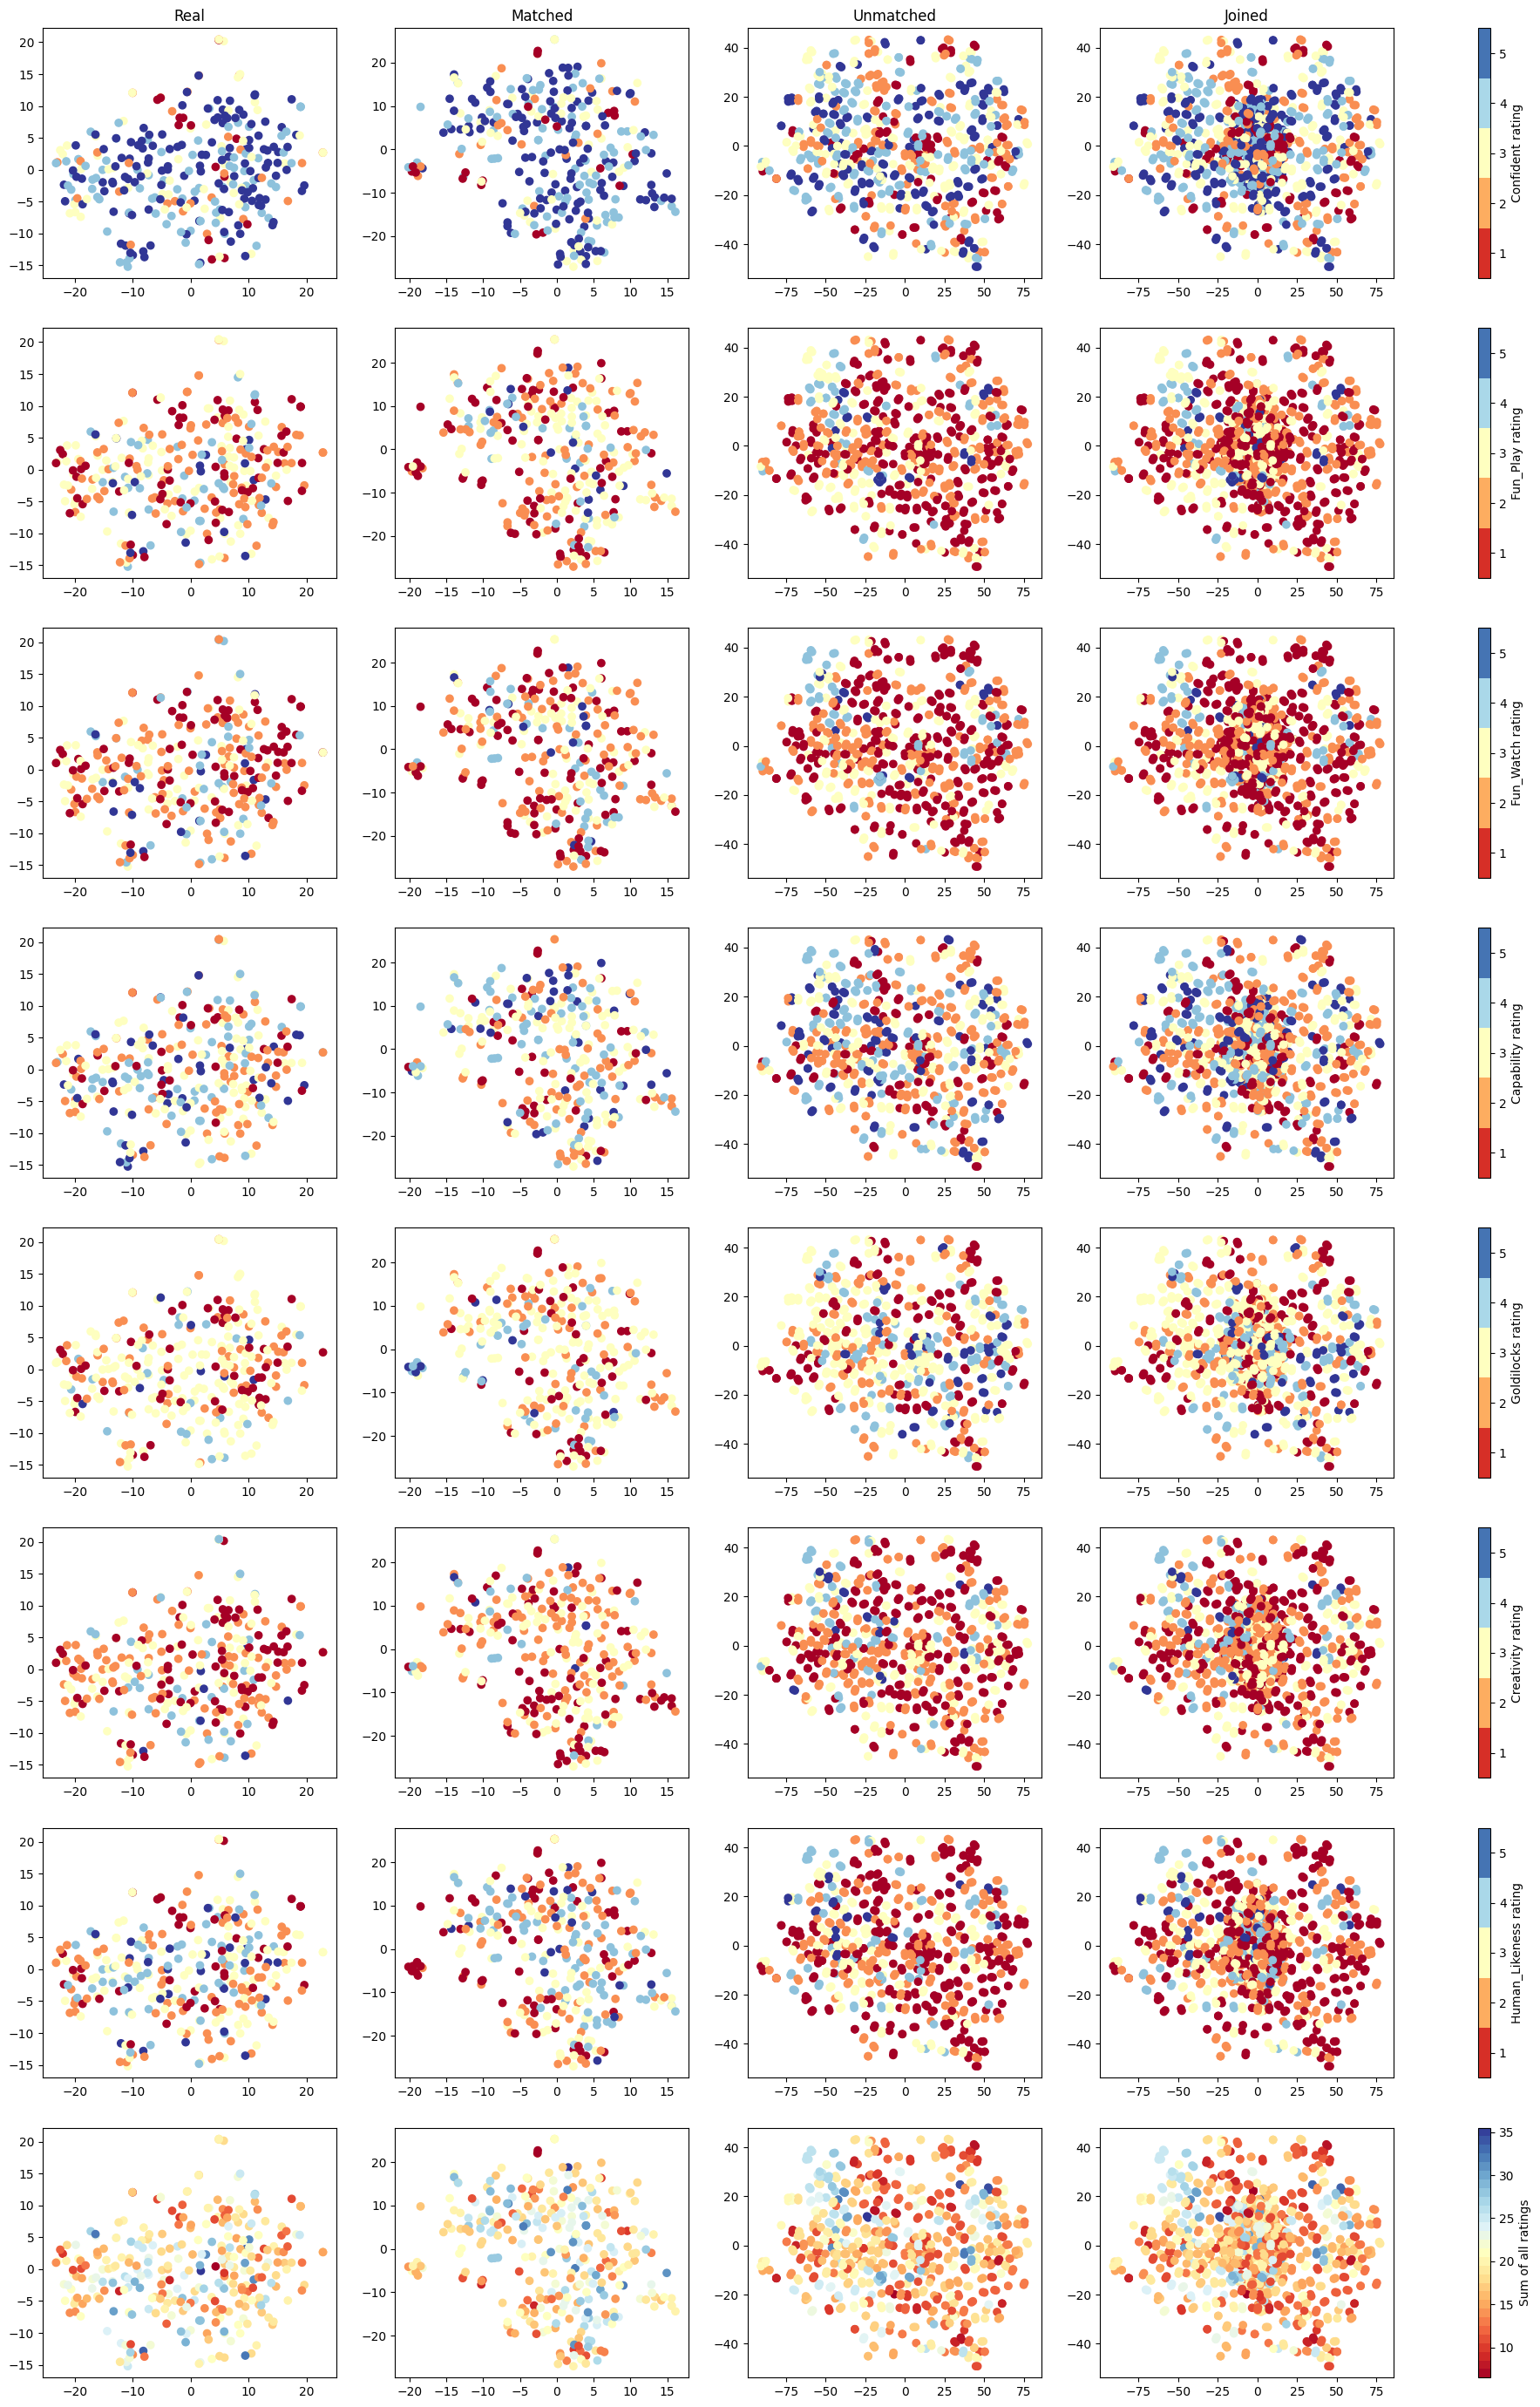

In [173]:
# Next, make 3 subplots for each game type and for each numerical attribute
fig, ax = plt.subplots(len(NUMBER_SCORE_ATTRIBUTES) + 1, 4, figsize=(25, 35))
colormap = plt.cm.get_cmap('RdYlBu')

for idx, attribute in enumerate(NUMBER_SCORE_ATTRIBUTES):

    ax[idx][0].scatter(real_games_df["overall_tsne1"], real_games_df["overall_tsne2"], c=real_games_df[attribute], label='Real', cmap=colormap)
    if idx == 0: ax[idx][0].set_title('Real')

    ax[idx][1].scatter(matched_games_df["overall_tsne1"], matched_games_df["overall_tsne2"], c=matched_games_df[attribute], label='Matched', cmap=colormap)
    if idx == 0: ax[idx][1].set_title('Matched')

    ax[idx][2].scatter(unmatched_games_df["overall_tsne1"], unmatched_games_df["overall_tsne2"], c=unmatched_games_df[attribute], label='Unmatched', cmap=colormap)
    if idx == 0: ax[idx][2].set_title('Unmatched')

    ax[idx][3].scatter(joined_df["overall_tsne1"], joined_df["overall_tsne2"], c=joined_df[attribute], label='Joined', cmap=colormap)
    if idx == 0: ax[idx][3].set_title('Joined')

    plt.colorbar(cm.ScalarMappable(cmap=colormap), ax=ax[idx], values=[1, 2, 3, 4, 5], label=f'{attribute.title()} rating')

# Same plot with the sum of all numerical ratings
attribute = 'sum_ratings'
ax[-1][0].scatter(real_games_df["overall_tsne1"], real_games_df["overall_tsne2"], c=real_games_df[attribute], label='Real', cmap=colormap)
ax[-1][1].scatter(matched_games_df["overall_tsne1"], matched_games_df["overall_tsne2"], c=matched_games_df[attribute], label='Matched', cmap=colormap)
ax[-1][2].scatter(unmatched_games_df["overall_tsne1"], unmatched_games_df["overall_tsne2"], c=unmatched_games_df[attribute], label='Unmatched', cmap=colormap)
ax[-1][3].scatter(joined_df["overall_tsne1"], joined_df["overall_tsne2"], c=joined_df[attribute], label='Joined', cmap=colormap)
plt.colorbar(cm.ScalarMappable(cmap=colormap), ax=ax[-1], values=list(range(7, 36)), label='Sum of all ratings')

## Group Classification

In [215]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold
from tqdm import tqdm

# Train a simple MLP classifier to see if we can predict the game type from the embeddings
X = np.array(joined_df["overall_embedding"].values.tolist())
y = np.array(joined_df["game_type"].cat.codes)

kf = KFold(n_splits=5, random_state=42, shuffle=True)
accuracies = []

for train_index, test_index in tqdm(kf.split(X), desc='Training MLP classifier on folds', total=5):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf = MLPClassifier(random_state=1, max_iter=2500).fit(x_train, y_train)
    accuracies.append(clf.score(x_test, y_test))

print(f"Mean accuracy on 5-fold CV for [overall] embeddings: {np.mean(accuracies)}")

Training MLP classifier on folds: 0it [00:00, ?it/s]

/Users/gray/anaconda3/envs/game-gen/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
Training MLP classifier on folds: 1it [00:06,  6.33s/it]/Users/gray/anaconda3/envs/game-gen/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
Training MLP classifier on folds: 2it [00:15,  7.84s/it]/Users/gray/anaconda3/envs/game-gen/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
Training MLP classifier on folds: 3it [00:22,  7.57s/it]/Users/gray/anaconda3/envs/game-gen/lib/python3.11/site-packages/sk

Mean accuracy on 5-fold CV for [overall] embeddings: 0.3026188979677352


In [216]:
X = np.array(joined_df["explain_embedding"].values.tolist())
y = np.array(joined_df["game_type"].cat.codes)

kf = KFold(n_splits=5, random_state=42, shuffle=True)
accuracies = []

for train_index, test_index in tqdm(kf.split(X), desc='Training MLP classifier on folds', total=5):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf = MLPClassifier(random_state=1, max_iter=2500).fit(x_train, y_train)
    accuracies.append(clf.score(x_test, y_test))

print(f"Mean accuracy on 5-fold CV for [explanation] embeddings: {np.mean(accuracies)}")

Training MLP classifier on folds:   0%|          | 0/5 [00:00<?, ?it/s]/Users/gray/anaconda3/envs/game-gen/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
Training MLP classifier on folds:  20%|██        | 1/5 [00:05<00:20,  5.09s/it]/Users/gray/anaconda3/envs/game-gen/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
Training MLP classifier on folds: 100%|██████████| 5/5 [00:28<00:00,  5.76s/it]

Mean accuracy on 5-fold CV for [explanation] embeddings: 0.49377151237616346


In [212]:
# Combine both embeddings and train a classifier
X = np.concatenate((np.array(joined_df["overall_embedding"].values.tolist()), np.array(joined_df["explain_embedding"].values.tolist())), axis=1)
y = np.array(joined_df["game_type"].cat.codes)

kf = KFold(n_splits=5, random_state=42, shuffle=True)
accuracies = []

for train_index, test_index in tqdm(kf.split(X), desc='Training MLP classifier on folds', total=5):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf = MLPClassifier(random_state=1, max_iter=2500).fit(x_train, y_train)
    accuracies.append(clf.score(x_test, y_test))

print(f"Mean accuracy on 5-fold CV for [combined] embeddings: {np.mean(accuracies)}")

Accuracy of MLP classifier on combined embeddings: 0.22007722007722008
